<a href="https://colab.research.google.com/github/MrckHckr/satellite-health-monitoring/blob/main/notebooks/02_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection on Satellite Telemetry
# Isolation Forest – Anomalie prima del guasto – Alerting operativo

This notebook applies anomaly detection techniques to satellite telemetry
to identify abnormal behavior before subsystem failures occur.

Technique:
- Isolation Forest

Operational goal:
- Early warning alerts for satellite operators


In [1]:
# Import librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest


In [2]:
# Caricamento telemetria da GitHub
url = "https://raw.githubusercontent.com/MrckHckr/satellite-health-monitoring/main/data/raw/telemetry.csv"

df = pd.read_csv(url, parse_dates=["timestamp"])
df.head()


,timestamp,temperature,battery_voltage,vibration,power,subsystem,failed
0,2025-01-01 00:00:00,22.3,28.1,0.02,120,battery,0
1,2025-01-01 01:00:00,22.8,28.0,0.02,119,battery,0
2,2025-01-01 02:00:00,23.5,27.8,0.03,118,battery,0
3,2025-01-01 03:00:00,25.2,27.2,0.05,115,battery,1


In [3]:
# Selezione sottosistema (batteria)
battery_df = df[df["subsystem"] == "battery"].copy()
battery_df.reset_index(drop=True, inplace=True)


In [4]:
# Feature engineering (sensori chiave)
features = battery_df[[
    "temperature",
    "vibration",
    "power"
]]


In [5]:
# Addestramento Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

battery_df["anomaly"] = iso_forest.fit_predict(features)


In [6]:
# Anomalie rilevate
battery_df["anomaly"].value_counts()


,count
anomaly,
1,3
-1,1


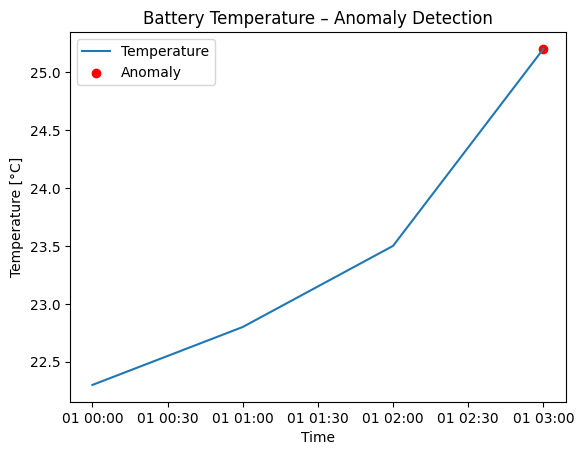

In [7]:
# Visualizzazione anomalie vs tempo
# Temperatura con anomalie evidenziate
plt.figure()
plt.plot(
    battery_df["timestamp"],
    battery_df["temperature"],
    label="Temperature"
)

anomalies = battery_df[battery_df["anomaly"] == -1]

plt.scatter(
    anomalies["timestamp"],
    anomalies["temperature"],
    color="red",
    label="Anomaly"
)

plt.legend()
plt.title("Battery Temperature – Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.show()


In [8]:
# Verifica: anomalie PRIMA del guasto
battery_df[battery_df["failed"] == 1].head()

pre_failure_anomalies = battery_df[
    (battery_df["anomaly"] == -1) &
    (battery_df["failed"] == 0)
]

pre_failure_anomalies.tail()


,timestamp,temperature,battery_voltage,vibration,power,subsystem,failed,anomaly


In [9]:
# ALERTING OPERATIVO (Mission Control)
def generate_alert(row):
    return (
        f"⚠️ ALERT | Time: {row['timestamp']} | "
        f"T={row['temperature']}°C | "
        f"Vib={row['vibration']}g | "
        f"P={row['power']}W"
    )

alerts = battery_df[battery_df["anomaly"] == -1]

for _, row in alerts.iterrows():
    print(generate_alert(row))


⚠️ ALERT | Time: 2025-01-01 03:00:00 | T=25.2°C | Vib=0.05g | P=115W


# Valore operativo
## Operational Impact

- Early anomaly detection before failures
- Reduced risk of unexpected subsystem outages
- Improved decision-making for satellite operators
- Reduced operational costs

